# Predicting Bundesliga Match Results

In this project, we'll use Bundesliga match logs to build a model on predicting the winner of a match. We have scraped data from [https://fbref.com](https://fbref.com) and created a csv file in a separate notebook.

Our data spans six full seasons. We'll compare the performances of random forest, ridge and support vector classifiers from sklearn and xgboost classifier on our data set.

## Cleaning the data set

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, RocCurveDisplay
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('match_data.csv')
df.shape

(3672, 40)

In [3]:
df.head()

,Unnamed: 0,date,time,round,day,venue,result,gf,ga,opponent,...,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
0,1,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eint Frankfurt,...,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich
1,2,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,...,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich
2,3,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,...,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich
3,4,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,M'Gladbach,...,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich
4,6,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,...,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# Check if there are any missing matches
df['round'].value_counts().sort_values()

round
Matchweek 1     108
Matchweek 4     108
Matchweek 5     108
Matchweek 6     108
Matchweek 7     108
Matchweek 8     108
Matchweek 9     108
Matchweek 10    108
Matchweek 11    108
Matchweek 12    108
Matchweek 13    108
Matchweek 14    108
Matchweek 15    108
Matchweek 16    108
Matchweek 17    108
Matchweek 18    108
Matchweek 19    108
Matchweek 33    108
Matchweek 26    108
Matchweek 20    108
Matchweek 21    108
Matchweek 22    108
Matchweek 23    108
Matchweek 24    108
Matchweek 3     108
Matchweek 25    108
Matchweek 2     108
Matchweek 28    108
Matchweek 29    108
Matchweek 30    108
Matchweek 31    108
Matchweek 32    108
Matchweek 27    108
Matchweek 34    108
Name: count, dtype: int64

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
pd.set_option('display.max_columns', None)
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
0,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eint Frankfurt,4.0,0.9,63.0,51500.0,Manuel Neuer,4-4-2,Deniz Aytekin,23.0,10.0,16.6,1.0,0.0,0.0,2.0,1.0,0.0,0.0,572.0,661.0,10072.0,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich
1,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,2.0,0.5,68.0,75000.0,Manuel Neuer,4-2-3-1,Harm Osmers,24.0,8.0,18.4,0.0,0.0,0.0,2.0,2.0,0.0,0.0,549.0,648.0,9680.0,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich
2,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,2.9,0.7,64.0,26000.0,Manuel Neuer,4-4-2,Daniel Siebert,21.0,11.0,18.3,1.0,1.0,1.0,7.0,7.0,0.0,0.0,462.0,545.0,7943.0,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich
3,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,M'Gladbach,2.8,0.5,69.0,75000.0,Manuel Neuer,4-2-2-2,Daniel Schlager,33.0,20.0,17.4,1.0,0.0,0.0,3.0,2.0,0.0,0.0,576.0,675.0,9943.0,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich
4,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,1.5,0.3,74.0,22012.0,Manuel Neuer,4-2-3-1,Frank Willenborg,21.0,6.0,18.1,0.0,0.0,0.0,2.0,1.0,0.0,0.0,657.0,762.0,10395.0,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich


There are inconsistencies in the team names in `team` and `opponent` columns; below we look at the different occurences of the same team, and standardize the names.

In [8]:
team_set = set(df['team'].unique())
opp_set = set(df['opponent'].unique())

diff = (team_set - opp_set) | (opp_set - team_set)
diff


{'Bayer Leverkusen',
 'Dusseldorf',
 'Düsseldorf',
 'Eint Frankfurt',
 'Eintracht Frankfurt',
 'Greuther Furth',
 'Greuther Fürth',
 'Koln',
 'Köln',
 'Leverkusen',
 "M'Gladbach",
 'Monchengladbach',
 'Nurnberg',
 'Nürnberg'}

In [9]:
map_values = {
    'Koln':'Köln',
    'Leverkusen': 'Bayer Leverkusen',
    'Dusseldorf': 'Düsseldorf',
    'Eint Frankfurt': 'Eintracht Frankfurt',
    'Greuther Furth': 'Greuther Fürth',
    "M'Gladbach": 'Monchengladbach',
    'Nurnberg': 'Nürnberg'
}

df.replace({'team':map_values, 'opponent':map_values}, inplace=True)

We need to take care of null values in order to use most machine learning models. Below we observe that the `attendance` column has a lot of null values. We remove this column altogether since it is not necessary for our purposes. We also observe that all other null values appear in three rows, which we also remove.

In [10]:
df.isna().sum().sort_values(ascending=False)

attendance    744
dist            3
fk              2
xg              2
cmp             2
att             2
totdist         2
prgdist         2
live            2
xga             2
dead            2
tb              2
sw              2
ti              2
ck              2
sota            0
crs             0
pksv            0
season          0
pka             0
saves           0
date            0
pkatt           0
opponent        0
round           0
day             0
venue           0
result          0
gf              0
ga              0
poss            0
pk              0
captain         0
formation       0
referee         0
sh              0
sot             0
time            0
team            0
dtype: int64

In [11]:
df.drop('attendance', axis=1, inplace=True)

In [12]:
df[df['dist'].isna()]

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
944,2022-03-18,20:30,Matchweek 27,Fri,Away,W,2,0,Bochum,NaN,NaN,49.0,Yann Sommer,3-4-3,Benjamin Cortus,8.0,5.0,NaN,NaN,0.0,0.0,7.0,7.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,2021-2022,Monchengladbach
1046,2022-03-18,20:30,Matchweek 27,Fri,Home,L,0,2,Monchengladbach,NaN,NaN,51.0,Anthony Losilla,4-3-3,Benjamin Cortus,16.0,7.0,NaN,NaN,0.0,0.0,5.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,2021-2022,Bochum
1707,2020-11-21,15:30,Matchweek 8,Sat,Home,L,1,2,Bayer Leverkusen,0.0,1.2,31.0,Fabian Klos,4-1-4-1,Felix Brych,0.0,0.0,NaN,0.0,0.0,0.0,4.0,2.0,0.0,0.0,239.0,365.0,4896.0,2155.0,326.0,36.0,0.0,1.0,9.0,18.0,0.0,2020-2021,Arminia


In [13]:
df.drop(df[df['dist'].isna()].index, inplace=True)


In [14]:
# Check total number of null values
df.isna().sum().sum()

0

## Selecting features

The values in our target column consist of three categories: W(in), D(raw), and L(ose). We'll simplify our target into two categories corresponding to whether the team has won or not.

In [15]:
df['target'] = (df['result'] == 'W').astype(int)

In [16]:
df['target'].value_counts()

target
0    2287
1    1382
Name: count, dtype: int64

There are a couple of columns containing categorical data that are relevant for our purposes. Below we encode these columns into a numerical format. We also simplify a couple of time related columns.

In [17]:
df['venue_code'] = (df['venue'] == 'Home').astype(int)

In [18]:
df['opp_code'] = df['opponent'].astype('category').cat.codes

In [19]:
teams = df[['opponent', 'opp_code']][~df['opponent'].duplicated()]
teams

,opponent,opp_code
0,Eintracht Frankfurt,7
1,Wolfsburg,24
2,Bochum,4
3,Monchengladbach,16
4,Union Berlin,22
5,Stuttgart,21
6,Augsburg,1
7,Bayer Leverkusen,2
8,Dortmund,5
9,Freiburg,8


In [20]:
# Apply the same category codes as 'opp_code' to 'team_code'
teams_dict = dict(zip(teams['opponent'], teams['opp_code']))
df['team_code'] = df['team'].map(teams_dict)

In [21]:
df['hour'] = df['time'].str.replace(r":.+", '', regex=True).astype(int)

In [22]:
df['day_code'] = df['date'].dt.dayofweek

In [23]:
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team,target,venue_code,opp_code,team_code,hour,day_code
0,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eintracht Frankfurt,4.0,0.9,63.0,Manuel Neuer,4-4-2,Deniz Aytekin,23.0,10.0,16.6,1.0,0.0,0.0,2.0,1.0,0.0,0.0,572.0,661.0,10072.0,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich,1,0,7,3,20,4
1,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,2.0,0.5,68.0,Manuel Neuer,4-2-3-1,Harm Osmers,24.0,8.0,18.4,0.0,0.0,0.0,2.0,2.0,0.0,0.0,549.0,648.0,9680.0,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich,1,1,24,3,17,6
2,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,2.9,0.7,64.0,Manuel Neuer,4-4-2,Daniel Siebert,21.0,11.0,18.3,1.0,1.0,1.0,7.0,7.0,0.0,0.0,462.0,545.0,7943.0,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich,1,0,4,3,17,6
3,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,Monchengladbach,2.8,0.5,69.0,Manuel Neuer,4-2-2-2,Daniel Schlager,33.0,20.0,17.4,1.0,0.0,0.0,3.0,2.0,0.0,0.0,576.0,675.0,9943.0,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich,0,1,16,3,18,5
4,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,1.5,0.3,74.0,Manuel Neuer,4-2-3-1,Frank Willenborg,21.0,6.0,18.1,0.0,0.0,0.0,2.0,1.0,0.0,0.0,657.0,762.0,10395.0,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich,0,0,22,3,15,5


Aside from the five features above, we'll use some numerical features in our models. These columns were obtained from several tables we scraped from links on each team page in a separate notebook.

In [24]:
num_cols = ['sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'sota', 'saves', 'pka',
       'pksv', 'cmp', 'att', 'totdist', 'prgdist', 'live', 'dead', 'tb', 'sw',
       'crs', 'ti', 'ck']

predictors = ['team_code', 'opp_code', 'venue_code', 'hour', 'day_code'] + num_cols

## Models

We'll keep the last season as our validation set, and the previous seaons will be our training set. In order to make sure we use previous match logs to predict later matches, we will use time series cross validation on our training set.

In [25]:
train = df[df['date'] < '2022-07-01']
val = df[df['date'] > '2022-07-01']

X = train[predictors]
y = train['target']

X_val = val[predictors]
y_val = val['target']

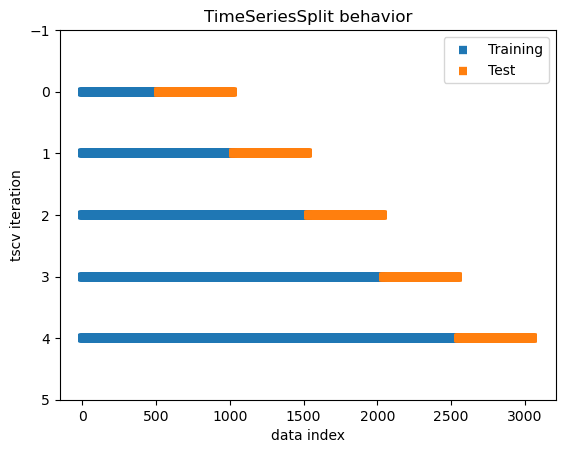

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

# Visualize the splits as a sanity check
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(tscv.split(X, y)):
    l1 = ax.scatter(tr, [ii] * len(tr), c='tab:blue',
                    marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c='tab:orange',
                    marker='_', lw=6)
ax.set(ylim=[5, -1],
       title='TimeSeriesSplit behavior',
       xlabel='data index', ylabel='tscv iteration')
ax.legend([l1, l2], ['Training', 'Test'])
plt.show()

We will use f1 score as our main metric.

In [27]:
f1_scorer = make_scorer(f1_score)

def scores(model, features):
    f1 = cross_val_score(model, X[features], y, cv=tscv, scoring=f1_scorer)
    print("Cross validation on training set:")
    print(f"f1 scores: {f1}")
    print(f"mean f1 score: {np.mean(f1)}")
    print(f"standard deviation of f1 scores: {np.std(f1)}", end='\n\n')

    model.fit(X[features], y)
    f1 = f1_score(y_val, model.predict(X_val[features]))
    print("Validation set:")
    print(f"f1 score: {f1}")

    cm = confusion_matrix(y_val, model.predict(X_val[features]))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = ['{0:0.0f}'.format(v) for v in cm.flatten()]
    percentages = ['{0:.2%}'.format(v) for v in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
    plt.show()

We'll apply a few machine learning models on our data set. For each model, we'll do the following:

1. Use training set and a pipeline to

    - determine the number of features to use
    - select these features
    - tune the parameters of the model using grid search  
<br>

2. Use training set and sequential feature selection with the parameters of the previuos step

3. Note the performance of the resulting model on both training and validation sets

### Model 1: Random forest classifier

In [28]:
pipe = Pipeline([
    ('feature_selection', SelectKBest()),
    ('classifier', RandomForestClassifier(random_state=1))
])

params = dict(
    feature_selection__k = list(range(5, 21, 5)),
    classifier__n_estimators = [100, 200, 300],
    classifier__min_samples_split = range(2, 11, 2),
    classifier__max_depth = range(3, 8)
)

gs = GridSearchCV(pipe,
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('feature_selection', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=1))]),
             param_grid={'classifier__max_depth': range(3, 8),
                         'classifier__min_samples_split': range(2, 11, 2),
                         'classifier__n_estimators': [100, 200, 300],
                         'feature_selection__k': [5, 10, 15, 20]},
             scoring=make_scorer(f1_score))

In [29]:
gs.best_params_

{'classifier__max_depth': 6,
 'classifier__min_samples_split': 6,
 'classifier__n_estimators': 200,
 'feature_selection__k': 10}

Now we use these parameters when defining our model.

In [30]:
rf = RandomForestClassifier(n_estimators=200,
                            min_samples_split=6,
                            max_depth=6,
                            random_state=1)
sfs = SequentialFeatureSelector(rf, 
                                n_features_to_select=10, 
                                direction="forward",
                                cv=tscv,
                                scoring=f1_scorer,
                                n_jobs=1
                               )
sfs.fit(X, y)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=RandomForestClassifier(max_depth=6,
                                                           min_samples_split=6,
                                                           n_estimators=200,
                                                           random_state=1),
                          n_features_to_select=10, n_jobs=1,
                          scoring=make_scorer(f1_score))

Cross validation on training set:
f1 scores: [0.67385445 0.71348315 0.71264368 0.69724771 0.6462585 ]
mean f1 score: 0.6886974962982134
standard deviation of f1 scores: 0.025621234829610418

Validation set:
f1 score: 0.6810551558752997


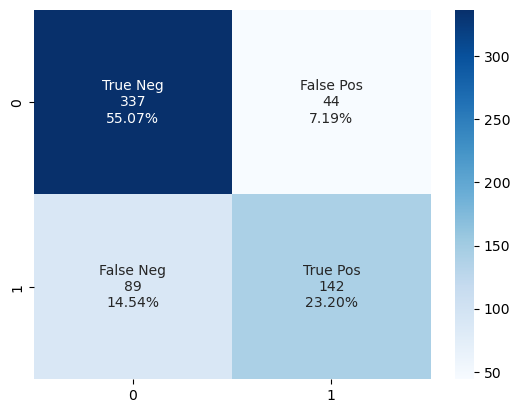

In [31]:
predictors_rf = list(np.array(predictors)[sfs.get_support()])

scores(rf, predictors_rf)

### Model 2: Ridge classifier

In [32]:
pipe = Pipeline([
    ('feature_selection', SelectKBest()),
    ('classifier', RidgeClassifier())
])

params = dict(
    feature_selection__k = list(range(5, 21, 5)),
    classifier__alpha = [round(a * 0.1, 1) for a in range(1, 11)]
)

gs = GridSearchCV(pipe,
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('feature_selection', SelectKBest()),
                                       ('classifier', RidgeClassifier())]),
             param_grid={'classifier__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                               0.7, 0.8, 0.9, 1.0],
                         'feature_selection__k': [5, 10, 15, 20]},
             scoring=make_scorer(f1_score))

In [33]:
gs.best_params_

{'classifier__alpha': 0.7, 'feature_selection__k': 20}

Now we use these parameters when defining our model.

In [34]:
rc = RidgeClassifier(alpha=0.7)
sfs = SequentialFeatureSelector(rc, 
                                n_features_to_select=20, 
                                direction="forward",
                                cv=tscv,
                                scoring=f1_scorer,
                                n_jobs=1
                               )
sfs.fit(X, y)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=RidgeClassifier(alpha=0.7),
                          n_features_to_select=20, n_jobs=1,
                          scoring=make_scorer(f1_score))

Cross validation on training set:
f1 scores: [0.8        0.77002584 0.80851064 0.8021978  0.76452599]
mean f1 score: 0.7890520548345495
standard deviation of f1 scores: 0.01808219661457157

Validation set:
f1 score: 0.7854077253218884


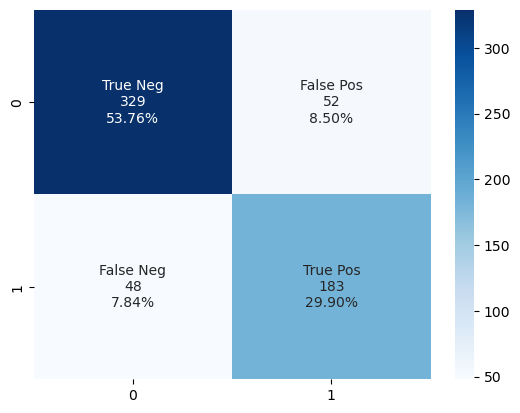

In [35]:
predictors_rc = list(np.array(predictors)[sfs.get_support()])

scores(rc, predictors_rc)

### Model 3: Support vector classifier

In [36]:
pipe = Pipeline([
    ('feature_selection', SelectKBest()),
    ('classifier', SVC())
])

params = dict(
    feature_selection__k = list(range(5, 21, 5)),
    classifier__C = [0.1, 1, 10]
    # classifier__kernel = ['linear', 'poly', 'rbf']
)

gs = GridSearchCV(pipe,
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('feature_selection', SelectKBest()),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'feature_selection__k': [5, 10, 15, 20]},
             scoring=make_scorer(f1_score))

In [37]:
gs.best_params_

{'classifier__C': 1, 'feature_selection__k': 5}

Now we use these parameters when defining our model.

In [38]:
svc = SVC(C=1)

sfs = SequentialFeatureSelector(svc, 
                                n_features_to_select=5, 
                                direction="forward",
                                cv=tscv,
                                scoring=f1_scorer,
                                n_jobs=1
                               )
sfs.fit(X, y)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=SVC(C=1), n_features_to_select=5, n_jobs=1,
                          scoring=make_scorer(f1_score))

Cross validation on training set:
f1 scores: [0.76070529 0.73658537 0.80506329 0.77747989 0.70930233]
mean f1 score: 0.7578272330016464
standard deviation of f1 scores: 0.03295948723596347

Validation set:
f1 score: 0.743362831858407


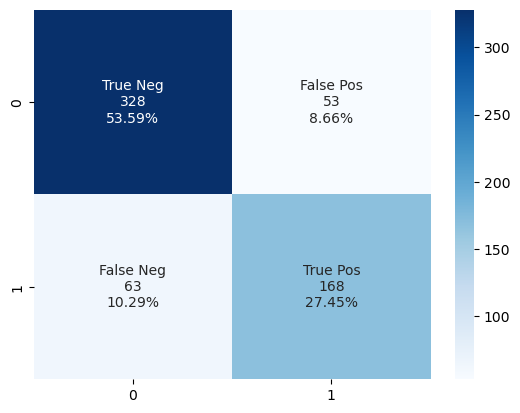

In [39]:
predictors_svc = list(np.array(predictors)[sfs.get_support()])

scores(svc, predictors_svc)

### Model 4: XGBoost Classifier

In [40]:
pipe = Pipeline([
    ('feature_selection', SelectKBest()),
    ('classifier', xgb.XGBClassifier())
])

params = dict(
    feature_selection__k = list(range(5, 21, 5)),
    classifier__max_depth = range(3, 8),
    classifier__learning_rate = [0.1, 0.01, 0.001],
    classifier__n_estimators = [100, 200, 300]
)

gs = GridSearchCV(pipe,
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('feature_selection', SelectKBest()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,...
                                                      min_child_weight=None,
                              

In [41]:
gs.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 200,
 'feature_selection__k': 20}

Now we use these parameters when defining our model.

In [42]:
xgbc = xgb.XGBClassifier(n_estimators=200,
                         learning_rate=0.1,
                         max_depth=3,
                         random_state=1)

sfs = SequentialFeatureSelector(xgbc,
                                n_features_to_select=20,
                                direction="forward",
                                cv=tscv,
                                scoring=f1_scorer,
                                n_jobs=1
                               )
sfs.fit(X, y)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, grow_p...
                                                  interaction_constraints=None,
                        

Cross validation on training set:
f1 scores: [0.72105263 0.75       0.7688172  0.79083095 0.7192429 ]
mean f1 score: 0.7499887367293928
standard deviation of f1 scores: 0.02758696018665776

Validation set:
f1 score: 0.7569892473118279


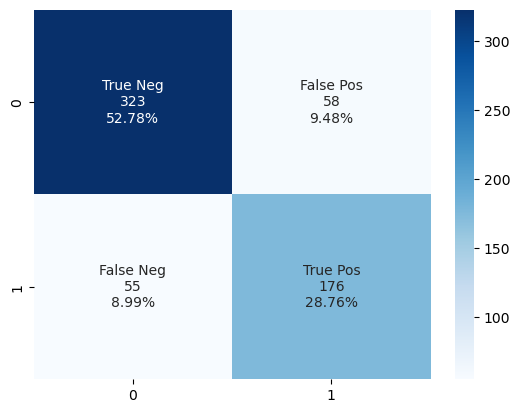

In [43]:
predictors_xgbc = list(np.array(predictors)[sfs.get_support()])

scores(xgbc, predictors_xgbc)

## Conclusion

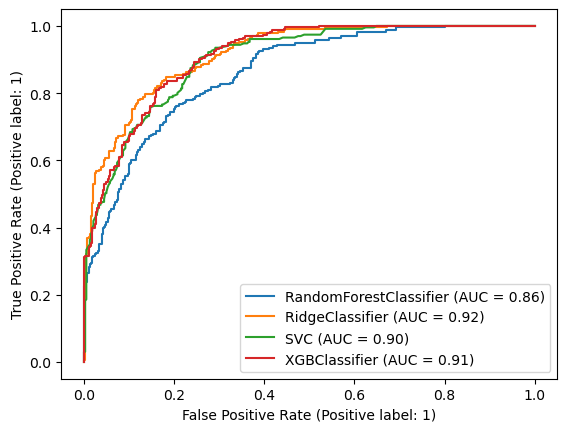

In [44]:
disp = RocCurveDisplay.from_estimator(rf, X_val[predictors_rf], y_val)
RocCurveDisplay.from_estimator(rc, X_val[predictors_rc], y_val, ax=disp.ax_)
RocCurveDisplay.from_estimator(svc, X_val[predictors_svc], y_val, ax=disp.ax_)
RocCurveDisplay.from_estimator(xgbc, X_val[predictors_xgbc], y_val, ax=disp.ax_)
plt.show()

F1 scores tell us that ridge classifier is the best model we have, and xgboost classifier is the second best with support vector classifier close behind. Plotting roc curves suggests the same conclusion while visualizing  differences in fit.

We can see by looking at the confusion matrices that ridge performs better than svc and xgboost on matches whose actual label is 1, while all three perform similarly where the actual label is 0.

Before concluding, it is necessary to note that our data set is small, and our target is imbalanced towards 0 (partly as a result of our combining losses and draws as 0), so our models may not be as trustworthy as the metric scores suggest.